In [1]:
#importing libraries
import requests
import lxml
import datetime
from netCDF4 import Dataset,num2date,date2index
from pydap.client import open_url 
from pydap.cas.urs import setup_session
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy.optimize
from dateutil.relativedelta import relativedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

In [3]:
# loads the shapefile for Nigeria, Delta and Rivers
nige = np.genfromtxt('nig.csv', delimiter = ',')
riv = np.genfromtxt('rivers1.csv', delimiter = ',')
delt = np.genfromtxt('delta1.csv', delimiter = ',')

In [4]:
# creating polygon for Rivers and Delta
PolyDT = []    # creating the polygon for MT
for k in range(len(delt[:,1])):
    PolyDT.append(tuple(delt[k,:]))
poly_DT = Polygon(PolyDT)

PolyRV = []    # creating the polygon for US
for j in range(len(riv[:,1])):
    PolyRV.append(tuple(riv[j,:]))
poly_RV = Polygon(PolyRV)

In [5]:
#plot the polygon for Rivers
poly_RV

In [6]:
#plot the polygon for Delta
poly_DT

In [7]:
# URL of Data from opendap
url = 'https://acdisc.gesdisc.eosdis.nasa.gov/opendap/CMS/GFEI_CH4.1/Global_Fuel_Exploitation_Inventory_GFEI_CH4_v1_2016.nc?lon[0:1:3599],lat[0:1:1799],oil_emis_ch4[0:1:1799][0:1:3599],gas_emis_ch4[0:1:1799][0:1:3599],coal_emis_ch4[0:1:1799][0:1:3599],total_fuel_exploitation_emis_ch4[0:1:1799][0:1:3599]'

In [8]:
username = 'leonardoh'   
password = 'Flonard0507!'
session = setup_session(username, password, check_url=url) # creating the earth data session
data = open_url(url, session=session)  # creating link to connect to dataset
data.keys

<bound method Mapping.keys of <DatasetType with children 'lon', 'lat', 'oil_emis_ch4', 'gas_emis_ch4', 'coal_emis_ch4', 'total_fuel_exploitation_emis_ch4'>>

In [9]:
oil_em = data.oil_emis_ch4# saving dataset as gws_ins

In [10]:
lat = data.lat[:].data # saves longitude
lon = data.lon[:].data # saves latitude
oil_emis = data.oil_emis_ch4.array[:].data # saves methane from oil variable
gas_emis = data.gas_emis_ch4.array[:].data # saves methane from gas variable
total_emis = data.total_fuel_exploitation_emis_ch4.array[:].data # saves total methane emission variable
coal_emis = data.coal_emis_ch4.array[:].data # saves methane from coal variable
fillVal = oil_em._FillValue #assigns the variable for missing value to a variable

lon_grid,lat_grid = np.meshgrid(lon,lat) # converts longitude and latitude to grid

In [11]:
oil_emis[oil_emis<=0.1] = np.nan
gas_emis[gas_emis<=0.1] = np.nan
total_emis[total_emis<=0.1] = np.nan
coal_emis[coal_emis<=0.1] = np.nan


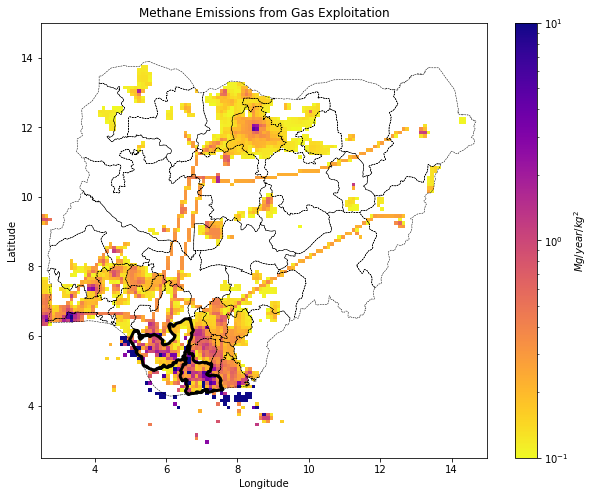

In [12]:
fig = plt.figure(figsize=(10,8))
cax=plt.pcolormesh(lon_grid,lat_grid, gas_emis[:], norm=colors.LogNorm(vmin=0.1, vmax=10), shading='auto', cmap='plasma_r')
plt.plot(nige[:,0],nige[:,1],'k--',linewidth=0.5)
plt.plot(riv[:,1],riv[:,0],'k-',linewidth=3.0)
plt.plot(delt[:,1],delt[:,0],'k-',linewidth=3.0)
#color_map = plt.cm.get_cmap('hot')
cbar=fig.colorbar(cax)
cbar.set_label('$Mg/year/kg^2$')
plt.xlim(2.5,15) # xaxis limit
plt.ylim(2.5,15) # yaxis limit
plt.xlabel('Longitude') # x-axis label
plt.ylabel('Latitude') # y-axis label
plt.title('Methane Emissions from Gas Exploitation')
#plt.savefig("Nigeria_methane.jpg", dpi = 600)
plt.show()

In [15]:
# mask array containing only 0, of size lon x lat, change DT to RV and run the code again for Rivers State
DTMask = np.zeros(gas_emis.shape[:])

# nested loop to check if points inside polygon and fill the mask

# iterate through longitude array
for lo_i in range(len(lon)):

    # iterate through latitude array
    for la_i in range(len(lat)):
        
        # set current lon/lat
        lo = lon[lo_i]  # current longitude coord in iteration
        la = lat[la_i]  # current latitude coord in iteration
        
        # create current point
        currentPoint = Point(la,lo)
        
        # check if point inside: returns true or false
        check = currentPoint.within(poly_DT)
        DTMask[la_i,lo_i] = int(check)

(2.5, 15.0)

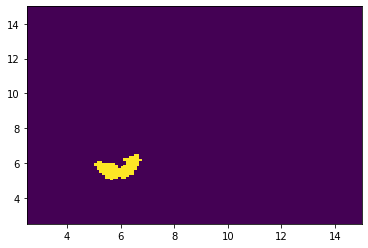

In [16]:
#Test mask
plt.pcolormesh(lon_grid,lat_grid, DTMask,shading='auto')
plt.xlim(2.5,15) # xaxis limit
plt.ylim(2.5,15) # yaxis limit

In [17]:
# creating emission for Delta and Rivers
DT_gasemis = gas_emis[:]*DTMask
RV_gasemis = gas_emis[:]*RVMask

In [18]:
# calculate mean for Rivers and Delta
print(np.nanmean(DT_gasemis[:]))
print(np.nanmean(RV_gasemis[:]))

0.0008298119033460703
0.0015943460304370602


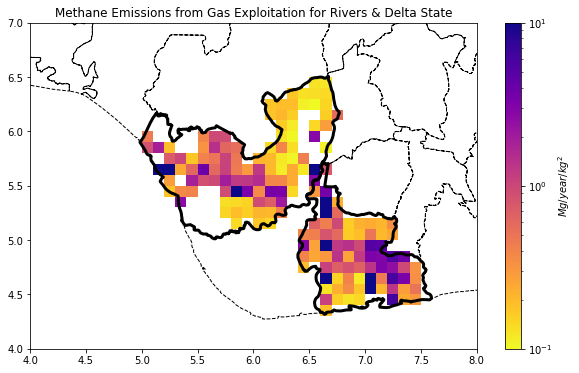

In [185]:
# Plot figure for Delta and Rivers
fig = plt.figure(figsize=(10,6))
cax=plt.pcolormesh(lon_grid,lat_grid, DT_gasemis[:], norm=colors.LogNorm(vmin=0.1, vmax=10), shading='auto', cmap='plasma_r')
plt.pcolormesh(lon_grid,lat_grid, RV_gasemis[:], norm=colors.LogNorm(vmin=0.1, vmax=10), shading='auto', cmap='plasma_r')
plt.plot(nige[:,0],nige[:,1],'k--',linewidth=1.0)
plt.plot(riv[:,1],riv[:,0],'k-',linewidth=3.0)
plt.plot(delt[:,1],delt[:,0],'k-',linewidth=3.0)
cbar=fig.colorbar(cax)
cbar.set_label('$Mg/year/kg^2$')
plt.xlim(4,8) # xaxis limit
plt.ylim(4,7) # yaxis limit
plt.title('Methane Emissions from Gas Exploitation for Rivers & Delta State')
plt.savefig("methane_riv_Delta.jpg", dpi=600)
plt.show()